<a href="https://colab.research.google.com/github/dgwalters-1974/autoencoder/blob/main/anomaly_detector_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

results_overall = {}

# Load the dataset
file_path = '/content/sample_data/fixings_SmartXM_no empty_max indices.csv'
data = pd.read_csv(file_path)

# Preprocessing: Convert 'Date' to datetime and set it as index
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')
data.set_index('Date', inplace=True)

# Compute daily differences
data_daily_diff = data.diff().dropna()

results_overall['data'] = data
results_overall['data_diff'] = data_daily_diff

In [55]:
currencies = ['JPY', 'EUR', 'USD', 'AUD', 'NZD', 'CAD', 'GBP']

for currency in currencies:

  # Subset the dataset for columns containing 'currency'
  currency_data = data[[col for col in data.columns if currency in col]]

  # Compute daily differences
  currency_daily_diff = currency_data.diff().dropna()

  # Normalize the data
  scaler = MinMaxScaler()
  normalized_currency_data = scaler.fit_transform(currency_daily_diff)

  # Convert to PyTorch tensors
  currency_tensor = torch.tensor(normalized_currency_data, dtype=torch.float32)

  # Split data into training and testing sets
  train_size = int(0.8 * len(currency_tensor))
  test_size = len(currency_tensor) - train_size
  train_data, test_data = torch.utils.data.random_split(currency_tensor, [train_size, test_size])

  train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

  # Define the autoencoder architecture (ix32)(32x4)(4x32)(32xi)
  class Autoencoder(nn.Module):
      def __init__(self, input_dim):
          super(Autoencoder, self).__init__()
          self.encoder = nn.Sequential(
              nn.Linear(input_dim, 32),
              nn.ReLU(),
              nn.Linear(32, 4),
              nn.ReLU()
          )
          self.decoder = nn.Sequential(
              nn.Linear(4, 32),
              nn.ReLU(),
              nn.Linear(32, input_dim),
              nn.Sigmoid()
          )

      def forward(self, x):
          encoded = self.encoder(x)
          decoded = self.decoder(encoded)
          return decoded

  # Instantiate the autoencoder
  input_dim = currency_tensor.shape[1]
  autoencoder = Autoencoder(input_dim)

  # Define the optimizer and loss function
  optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
  criterion = nn.MSELoss()

  # Train the autoencoder
  num_epochs = 50
  for epoch in range(num_epochs):
      autoencoder.train()
      train_loss = 0
      for batch in train_loader:
          optimizer.zero_grad()
          reconstructed = autoencoder(batch)
          loss = criterion(reconstructed, batch)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
      train_loss /= len(train_loader)
      if epoch % 10 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.6f}")

  # Compute reconstruction errors on the entire dataset
  autoencoder.eval()
  with torch.no_grad():
      reconstructed_currency_data = autoencoder(currency_tensor)
      reconstruction_errors = torch.mean((currency_tensor - reconstructed_currency_data) ** 2, dim=1).numpy()

  # Identify anomalies (reconstruction error > 95th percentile)
  threshold = np.percentile(reconstruction_errors, 95)
  anomalies_indices = np.where(reconstruction_errors > threshold)[0]

  # Extract anomalies and add reconstruction errors
  anomalies = currency_daily_diff.iloc[anomalies_indices].copy()
  anomalies['Reconstruction_Error'] = reconstruction_errors[anomalies_indices]

  # Calculate feature contributions based on reconstruction differences
  contributions = np.abs(currency_tensor.numpy() - reconstructed_currency_data.numpy())
  feature_contributions = [dict(zip(currency_daily_diff.columns, contrib)) for contrib in contributions[anomalies_indices]]

  # Add feature contributions to the anomalies dataframe
  anomalies['Feature_Contributions'] = feature_contributions

  # Prepare the final anomalies table
  result_table = anomalies.reset_index()[['Date', 'Reconstruction_Error', 'Feature_Contributions']]

  # Display the result table
  #print(result_table.head())

  results_overall[currency] = result_table.sort_values('Date')




Epoch 1/50, Loss: 0.003951
Epoch 11/50, Loss: 0.002518
Epoch 21/50, Loss: 0.002021
Epoch 31/50, Loss: 0.001715
Epoch 41/50, Loss: 0.001106
Epoch 1/50, Loss: 0.068286
Epoch 11/50, Loss: 0.003851
Epoch 21/50, Loss: 0.003509
Epoch 31/50, Loss: 0.001991
Epoch 41/50, Loss: 0.001687
Epoch 1/50, Loss: 0.003442
Epoch 11/50, Loss: 0.001740
Epoch 21/50, Loss: 0.001249
Epoch 31/50, Loss: 0.001001
Epoch 41/50, Loss: 0.000798
Epoch 1/50, Loss: 0.004694
Epoch 11/50, Loss: 0.002272
Epoch 21/50, Loss: 0.001211
Epoch 31/50, Loss: 0.000634
Epoch 41/50, Loss: 0.000321
Epoch 1/50, Loss: 0.002404
Epoch 11/50, Loss: 0.001156
Epoch 21/50, Loss: 0.000412
Epoch 31/50, Loss: 0.000141
Epoch 41/50, Loss: 0.000094
Epoch 1/50, Loss: 0.010991
Epoch 11/50, Loss: 0.001498
Epoch 21/50, Loss: 0.001415
Epoch 31/50, Loss: 0.001241
Epoch 41/50, Loss: 0.001000
Epoch 1/50, Loss: 0.014006
Epoch 11/50, Loss: 0.001536
Epoch 21/50, Loss: 0.000493
Epoch 31/50, Loss: 0.000322
Epoch 41/50, Loss: 0.000201


In [56]:
def plot_results(plot_data, currency, anomalies):
  currency_data = plot_data[[col for col in plot_data.columns if currency in col]]
  for feature in currency_data.columns:
      plt.figure(figsize=(12, 6))

      # Plot the main line for the feature
      plt.plot(currency_data.index, currency_data[feature], label=feature, color='steelblue', alpha=0.7, linewidth=1.5)

      # Highlight anomalies
      anomaly_dates = anomalies['Date']
      anomaly_values = currency_data.loc[anomaly_dates, feature]
      plt.scatter(anomaly_dates, anomaly_values, color='darkred', label='Anomalies', zorder=5, s=30, alpha=0.8)

      # Add chart aesthetics
      plt.title(f"{feature} vs Date with Anomalies Highlighted", fontsize=14, fontweight='bold')
      plt.xlabel("Date", fontsize=12)
      plt.ylabel(feature, fontsize=12)
      plt.legend()
      plt.grid(alpha=0.3)
      plt.tight_layout()

      # Display the plot
      plt.show()




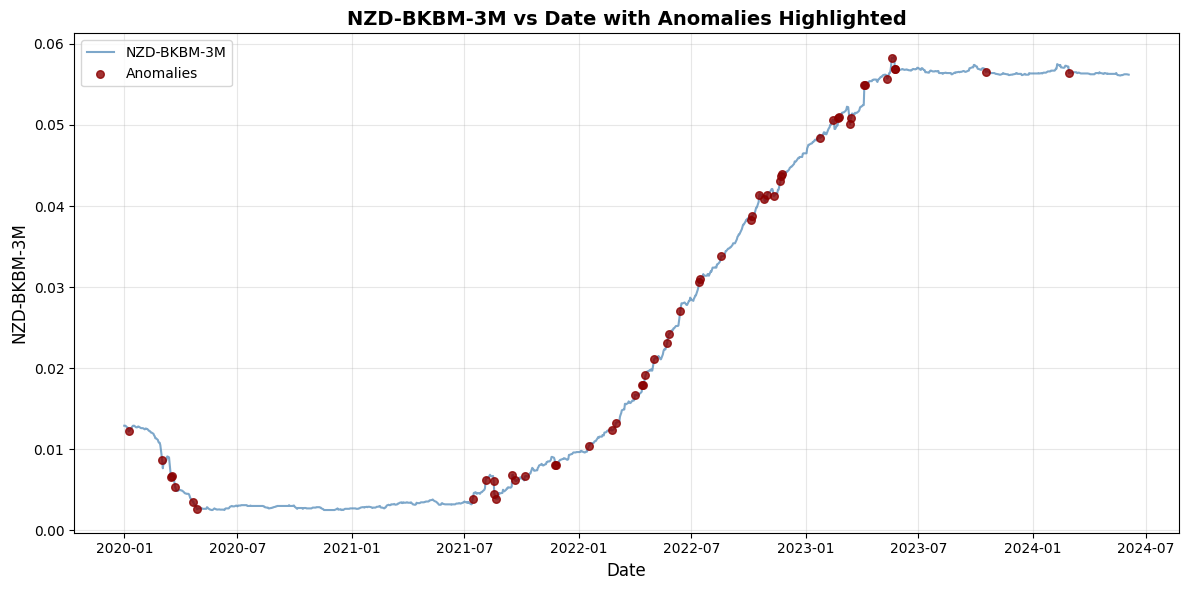

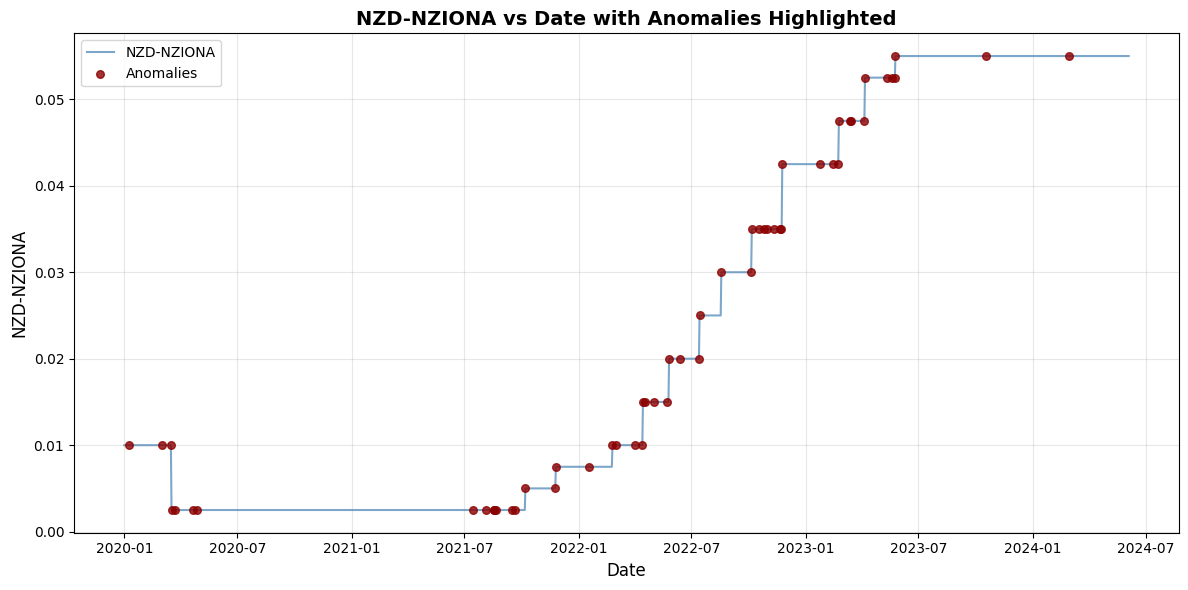

In [57]:
plot_data = results_overall['data'] # Plot outright data
currency = 'NZD'
anomalies = results_overall[currency]

plot_results(plot_data, currency, anomalies)

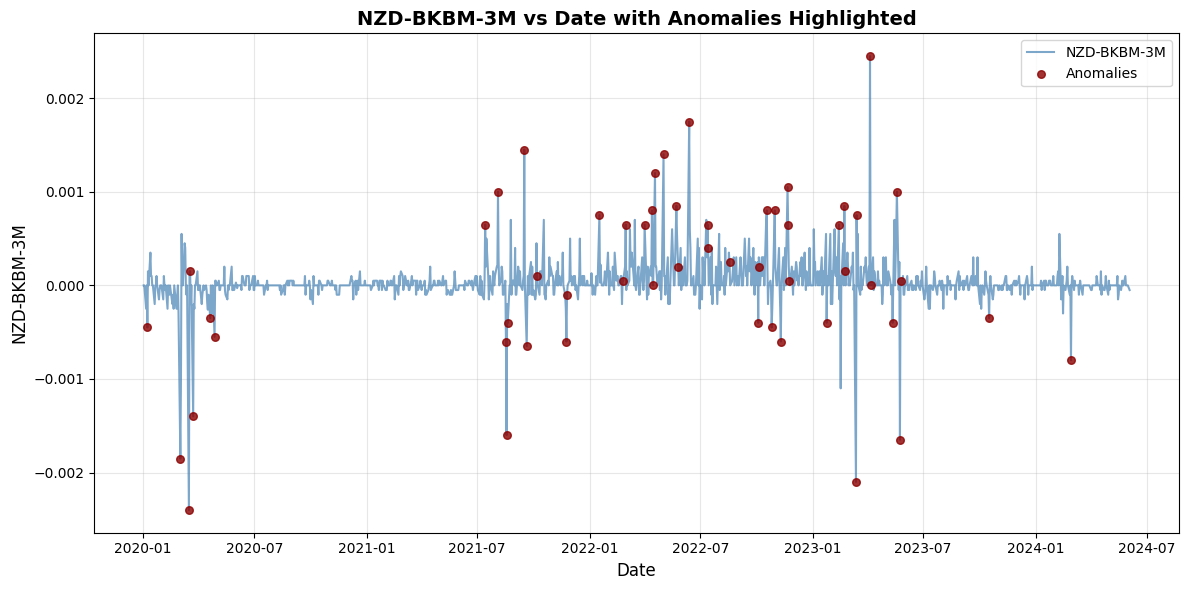

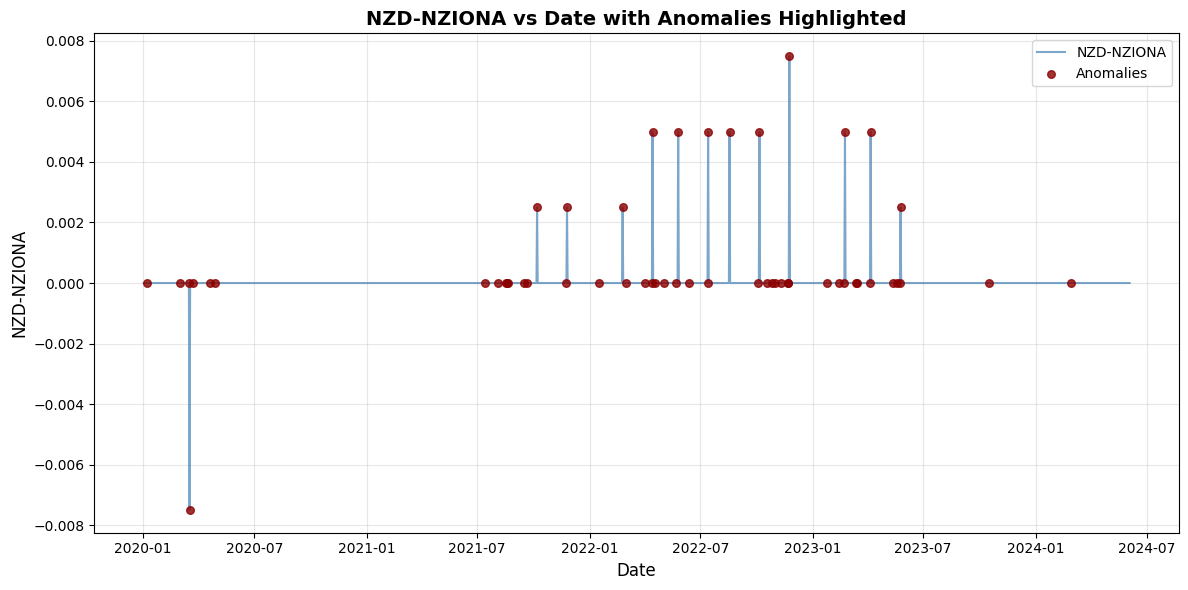

In [58]:
plot_data = results_overall['data_diff'] # Plot outright data
currency = 'NZD'
anomalies = results_overall[currency]
plot_results(plot_data, currency, anomalies)

In [59]:
# Not really sure if this is a good measure of how 'anomalous' the data is
overall_anomaly_score = {}

for curr in currencies:
  overall_anomaly_score[curr] = results_overall[curr]['Reconstruction_Error'].mean()

In [60]:
overall_anomaly_score

{'JPY': 0.017662685,
 'EUR': 0.0221583,
 'USD': 0.009212906,
 'AUD': 0.0034516207,
 'NZD': 0.0013220849,
 'CAD': 0.015014924,
 'GBP': 0.004274599}

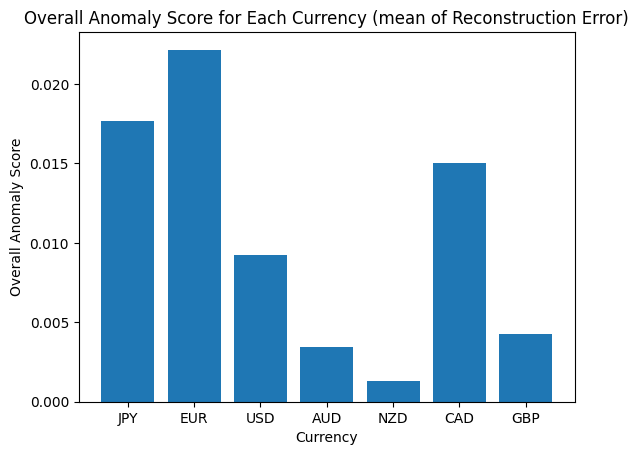

In [61]:
# Plot the 'overall' anomaly scores to get an idea about relative behaviour of each currency

import matplotlib.pyplot as plt

# D = {u'Label1':26, u'Label2': 17, u'Label3':30}

plt.bar(range(len(overall_anomaly_score)), list(overall_anomaly_score.values()), align='center')
plt.xticks(range(len(overall_anomaly_score)), list(overall_anomaly_score.keys()))
plt.xlabel('Currency')
plt.ylabel('Overall Anomaly Score')
plt.title('Overall Anomaly Score for Each Currency (mean of Reconstruction Error)')
plt.show();